In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the train and test data

In [22]:
df_train = pd.read_csv("train_data.txt", sep=" ", names=["col1", "col2", "col3"])
df_test = pd.read_csv("test_data.txt", sep=" ", names=["col1", "col2", "col3"])

In [23]:
df_train.head()  # sanity check

,col1,col2,col3
0,-4.072524,-9.577501,0.0
1,-3.591656,-4.651351,2.0
2,-1.621404,-10.069722,0.0
3,-2.352587,-9.027460,0.0
4,1.690682,-0.521923,1.0


In [24]:
df_test.head()  # sanity check

,col1,col2,col3
0,-0.577060,-9.426309,0.0
1,-2.289926,-9.661375,0.0
2,-1.724228,-3.966204,2.0
3,-4.080085,-9.351840,0.0
4,2.143670,-1.731809,1.0


In [25]:
x_train = df_train[["col1", "col2"]].astype(np.float32).values
y_train = df_train["col3"].astype(np.float32).values
x_test = df_test[["col1", "col2"]].astype(np.float32).values
y_test = df_test["col3"].astype(np.float32).values

# Question 3 [60 points]: Linear Classifier Implementations 

a) [35 points: 15 points for each model, 5 points for evaluation] Using the provided dataset in the notebook, implement the perceptron and linear discriminant analysis (LDA) algorithms (use NumPy, Pandas) to classify the dataset. Then, report the accuracy of trained models. 

In [26]:
class Perceptron:
  
  def __init__ (self):
    self.w = None
    self.threshold = None
    
  def model(self, x):
    #Return 1 if (w*x) greater than or equal to threshold - Else return 0.
    result = np.where(self.w.T @ x >= self.threshold, 1, 0)

    return np.squeeze(result)
  
  def predict(self, X):
    #Predict values for the input X using the 'model' function above and store it in Y
    Y = self.model(X)
    return np.array(Y)
    
  def fit(self, X, Y, epochs = 1, lr = 1):

    self.w = np.zeros(X.shape[1]).reshape(-1, 1)
    self.threshold = 0

    accuracy = {}
    max_accuracy = 0
    wt_matrix = []

    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.predict(x.reshape(-1, 1))

        if y == 1 and y_pred == 0:
          #Update the w and threshold
          self.w = self.w + (lr * x.T.reshape(-1, 1)) * y
          # TODO: do I need to update the threshold here also?
      
        elif y == 0 and y_pred == 1:
          # modify this part
          self.w = self.w - (lr * x.T.reshape(-1, 1))
          
      wt_matrix.append(self.w)    
      accuracy[i] = accuracy_score(self.predict(X.T), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.threshold
    #checkpoint (Save the best weights and b value)
    self.w = chkptw.reshape(-1, 1)
    self.threshold = chkptb
        
    print(max_accuracy)
    #plot the accuracy values over epochs
    plt.plot(accuracy.values())
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.show()
    
    #return the weight matrix, that contains weights over all epochs
    return np.array(wt_matrix)


0.668


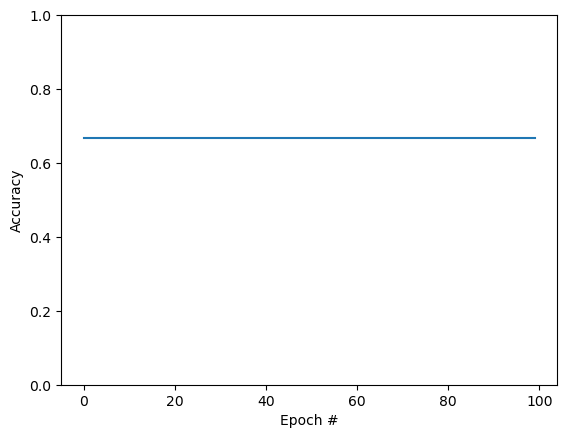

In [27]:
perceptron = Perceptron()
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
wt_matrix = perceptron.fit(x_train_scaled, y_train, 100, 0.001)

In [28]:
#Report the test accuracy for Perceptron. 
x_test_scaled = scaler.transform(x_test)
score = accuracy_score(perceptron.predict(x_test_scaled.T), y_test)
print(f"Test Accuracy: {round(score * 100, 2)}%.")

Test Accuracy: 66.67%.


In [29]:
import numpy as np

class LDA:
    '''
    Closed-form implementaion of linear discriminant analysis.

    Credit to the "Python Engineer" YouTube Lecture on LDA for explaining the math:
    https://www.youtube.com/watch?v=9IDXYHhAfGA
    '''
    def __init__(self, n_components):
        self.n_components = n_components  # after training + projection, this is how many dims we'll have
        self.linear_discriminants = None
        self.class_centroids = ...  # used for evaluation

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        mean_overall = np.mean(X, axis=0)
        scatter_within_cls = np.zeros((n_features, n_features))
        scatter_between_cls = np.zeros((n_features, n_features))
        for c in class_labels:
            samples_within_class = X[y == c]
            mean_class = np.mean(samples_within_class, axis=0)
            scatter_within_cls += (
                (samples_within_class - mean_class).T.dot((samples_within_class - mean_class))
            )
            n_c = samples_within_class.shape[0]
            mean_diff = (mean_class - mean_overall).reshape(n_features, 1)
            scatter_between_cls += n_c * (mean_diff).dot(mean_diff.T)

        # Determine scatter_within_cls^-1 * scatter_between_cls
        A = np.linalg.inv(scatter_within_cls).dot(scatter_between_cls)
        # Eigendecomposition of scatter_within_cls^-1 * scatter_between_cls
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T  # transpose used for easier calculations
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs] # eigenvector v = [:,i] column vector, 
        # maximize separability - store first n eigenvectors
        self.linear_discriminants = eigenvectors[:self.n_components]

    def transform(self, X):
        # project the data
        return np.dot(X, self.linear_discriminants.T)

    def evaluate(self, X, y):
        """
        Given a set of test data, output labels.
        To do this, we rely on the Euclidean distance of the
        transformed points to the nearest "centroid" point for all 
        the classes found (in the set of said transformed points).

        Assumes the labels in y are 0-indexed sparse ints.
        """
        # transform all the test data
        X_transformed = self.transform(X)
        # determine what the centroids will be
        centroids, class_labels = dict(), np.unique(y)
        for c in class_labels:
            samples_within_class = X_transformed[y == c]
            mean_class = np.mean(samples_within_class, axis=0)
            centroids[c] = mean_class
        # predict the class labels
        labels = list()
        centroid_pts = np.array(list(centroids.values()))
        for transformed_pt in X_transformed:
            centroid_assignment_index = np.argmin([
                np.linalg.norm(transformed_pt - centroid_pts, axis=1)  # Euclidean distance
            ])
            labels.append(class_labels[centroid_assignment_index])
        return labels


b)	[5 points] Use the provided test dataset, general and evaluate the models. 

0.668


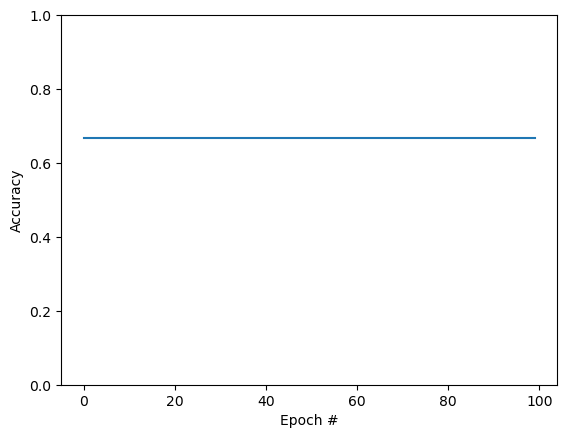

In [30]:
# Custom Perceptron - uses SGD
my_perceptron = Perceptron()
my_perceptron.fit(x_train_scaled, y_train, 100, 0.001)
my_perceptron_acc = accuracy_score(my_perceptron.predict(x_test_scaled.T), y_test)

LDA accuracy: 93.7%


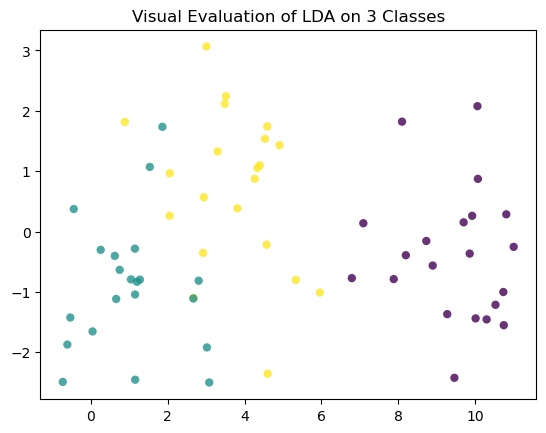

In [31]:
# Custom LDA model - closed form approach
my_lda = LDA(2)
my_lda.fit(x_train, y_train)
lds = my_lda.transform(x_test)

x1, x2 = lds[:, 0], lds[:, 1]

plt.scatter(
    x1, x2, c=y_test, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3)
)
plt.title("Visual Evaluation of LDA on 3 Classes")
my_lda_acc = accuracy_score(my_lda.evaluate(x_test, y_test), y_test)
print(f"LDA accuracy: {100 * round(my_lda_acc, 3)}%")

c)	[15 pts] Implement models (perceptron, LDA, and logistic regression) using Scikit-learn. 

In [32]:
from sklearn.linear_model import Perceptron as SKPerceptron

perceptron_sklearn = SKPerceptron(max_iter=100, random_state=0)
perceptron_sklearn.fit(x_train_scaled, y_train)
perceptron_acc = perceptron_sklearn.score(x_test_scaled, y_test)
print(f"Perceptron accuracy: {100 * round(perceptron_acc, 3)}%")

Perceptron accuracy: 81.0%


In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKLinDA

lda = SKLinDA(n_components=2)
lda.fit(x_train_scaled, y_train)
lda_acc = lda.score(x_test_scaled, y_test)
print(f"LDA accuracy: {100 * round(lda_acc, 3)}%")

LDA accuracy: 93.7%


In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=0)
log_reg.fit(x_train_scaled, y_train)
log_reg_acc = log_reg.score(x_test_scaled, y_test)
print(f"Logistic Regression accuracy: {100 * round(log_reg_acc, 3)}%")

Logistic Regression accuracy: 92.10000000000001%


d)	[5 points] Compare the weights obtained and the accuracies of trained models. Did you expect weights to be the same? Explain why or why not? 

In [35]:
print("====== LDA Report ========")
print(f"Custom LDA: \n\t - (accuracy): {100 * round(my_lda_acc, 3)}%")
print(f"\t - (weights): {my_lda.linear_discriminants}")
print(f"Sklearn LDA: \n\t - (accuracy): {100 * round(lda_acc, 3)}%")
print(f"\t - (weights): {lda.coef_}")
print("====== Perceptron Report ========")
print(f"Custom Perceptron: \n\t - (accuracy): {100 * round(my_perceptron_acc, 3)}%")
print(f"\t - (weights): {my_perceptron.w}")
print(f"Sklearn Perceptron: \n\t - (accuracy): {100 * round(perceptron_acc, 3)}%")
print(f"\t - (weights): {perceptron_sklearn.coef_}")
print("====== Logistic Regression Report ========")
print(f"Sklearn LogReg: \n\t - (accuracy): {100 * round(log_reg_acc, 3)}%")
print(f"\t - (weights): {log_reg.coef_}")


====== LDA Report ========
Custom LDA: 
	 - (accuracy): 93.7%
	 - (weights): [[-0.2451322  -0.96948966]
 [-0.97875977  0.20501053]]
Sklearn LDA: 
	 - (accuracy): 93.7%
	 - (weights): [[ -1.14282633 -14.84734219]
 [  2.14007624  10.94902853]
 [ -0.98348092   4.0771973 ]]
====== Perceptron Report ========
Custom Perceptron: 
	 - (accuracy): 66.7%
	 - (weights): [[0.00043479]
 [0.00235844]]
Sklearn Perceptron: 
	 - (accuracy): 81.0%
	 - (weights): [[ 0.50808543 -2.66590291]
 [ 2.49583924  5.49095953]
 [-1.96812744  1.55506819]]
====== Logistic Regression Report ========
Sklearn LogReg: 
	 - (accuracy): 92.10000000000001%
	 - (weights): [[-0.57434921 -4.00098888]
 [ 1.58302376  3.56062319]
 [-1.00867455  0.44036568]]


*LDA*:
As the reports above show, both the custom and `sklearn` implementations of LDA achieved ~93% accuracy. However they have different weights. This could be explained by our approach relying upon eigen decomposition while `sklearn` used SVD by default (albeit I'm not totally aware of the underlying details that affect the shape of the final model weights). Nonetheless, they are still both closed-form solutions so it makes sense that the final accuracy was the same.

*Perceptron*:
As the reports above show, the Sklearn implementation of the perceptron achieved a significantly higher accuracy (~81%) than our own (~66.7%). 
This could be due to simplicity of our class - for example, our implementation leaves out a bias term, l1 and l2 regularization, and there was no `if/elif` block to update the weights in case we mislabelled a sample from thr `2` class. In light of this, it seems reasonable that the Sklearn has more parameters - its implementation means that its decision boundary is parametrized to classify all 3 classes.

*Logistic Regression*:
This model had the 2nd highest accuracy 92% behind LDA. There is no custom implementation to compare to. I did not expect its weights to be the same as the other models, since it relies upon a maximum likelihood function, rather than the LDA and perceptron which depend on a more straightforward linear function.



# Question 4 [20 points]: Linear Regression and regularization

Suppose we decided to reject the linear model for the housing dataset discussed in linear regression lecture (the second model with all features after the preprocessing). Then, we are going to implement a new model that is less complex (lower number of features) and outperform (lower RMSE). 

a)	[10 points] Retrain the dataset. In the new trained dataset, same feature engineering for the continuous features is not allowed while the discrete features may be used as they are. For each process, explain explicitly the reason of work. 

In [36]:
df = pd.read_csv("../Lecture4_Linear_Regression/Housing_scaled_01.csv")

In [37]:
df.head()

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,-122.23,37.88,32.672294,8.208606,5.645033,7.675271,5.705034,2.728723,61.003713,3.113149,-2.957260,0.876915,0,0,0,1,0
1,1,-122.22,37.86,17.070476,11.413717,8.717972,11.487953,8.974699,2.724071,58.036799,2.848110,-2.822167,0.707407,0,0,0,1,0
2,8,-122.26,37.84,33.434943,9.799169,7.954136,10.099133,7.961036,0.797670,52.585885,2.062241,-1.811675,0.671329,0,0,0,1,0
3,15,-122.26,37.85,39.491212,8.560402,6.722807,9.055987,6.750997,0.822822,47.360433,2.038908,-1.864239,0.905250,0,0,0,1,0
4,18,-122.26,37.84,39.491212,9.597088,7.399371,9.717414,7.430798,0.746034,48.672270,2.506253,-2.271723,0.808116,0,0,0,1,0


By the powers of inductive reasoning, I think we can safely presume which features count as categorical and which are continuous:

In [38]:
features = list(set(df.columns.tolist()[3:])-set(['median_house_value']))
categorical_feat = ['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN', 'ISLAND']
continuous_feat = [
    'bedrooms_per_room', 'population', 'total_bedrooms', 'households', 'total_rooms', 
    'rooms_per_household', 'median_income', 'housing_median_age', 'population_per_household'
]
all_feature_data = df[features]
target = df["median_house_value"]

To avoid data-snooping bias, let's split the data right away (using 30% for test data):

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    all_feature_data, target, test_size=0.3, random_state=42
)

Next step - it's best to scale the data to a Gaussian distribution to increase the likelihood of convergence. I'll only do this to the continuous features:

In [41]:
housing_scaler = StandardScaler()
# do the scaling
X_train_cont_scaled = housing_scaler.fit_transform(X_train[continuous_feat])
X_test_cont_scaled = housing_scaler.transform(X_test[continuous_feat])

# overwrite the cont. feature cols w/ the scaled values
X_train_scaled = X_train.copy()
X_train_scaled[continuous_feat] = X_train_cont_scaled

X_test_scaled = X_test.copy()
X_test_scaled[continuous_feat] = X_test_cont_scaled

The easiest way to reduce the number of features we need here might be to do *feature selection*. In this case, I'll use a correlation heatmap to see which features are multicolinear - by this information we can choose to simply drop some features from the eventual model:

In [42]:
def make_heatmap(data, map_title):
   """Plots the diagonal correlation matrix of a dataset using Seaborn.
      Credit to the Seaborn Documentation for inspiring this cell:
      https://seaborn.pydata.org/examples/many_pairwise_correlations.html
      
      Parameters:
      df(pandas.DataFrame): encapsulates the dataset being used to make heatmap.
      map_title(str): the title for the heatmap
   
   """
   # Compute the correlation matrix
   corr = data.corr()
   # Generate a mask for the upper triangle
   mask = np.triu(np.ones_like(corr, dtype=np.bool))
   # Set up the matplotlib figure
   f, ax = plt.subplots(figsize=(12, 12))
   # Generate a custom diverging colormap
   cmap = sns.diverging_palette(220, 10, as_cmap=True)
   # Draw the heatmap with the mask and correct aspect ratio
   sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
   plt.title(map_title)
   plt.show()

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_53153/1975012964.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


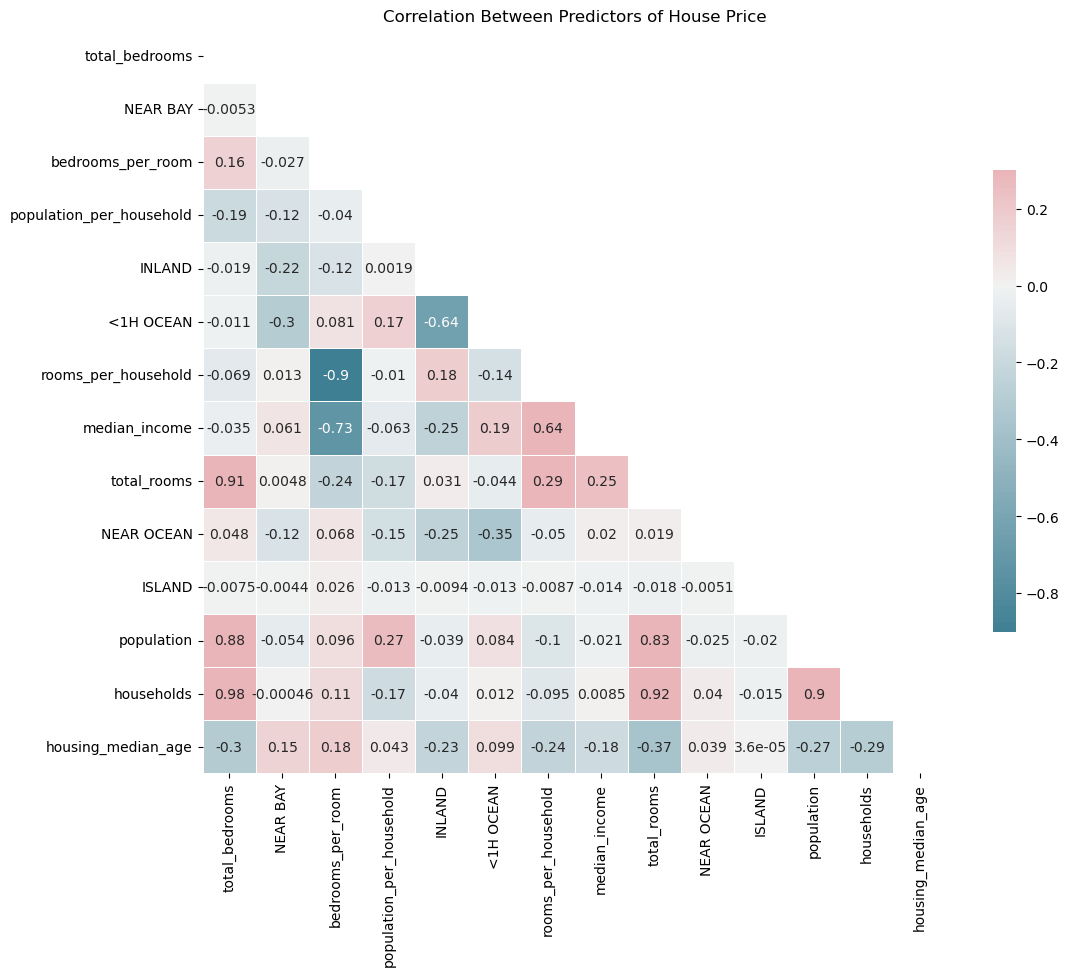

In [43]:
make_heatmap(X_train_scaled, 'Correlation Between Predictors of House Price')

Based on the plot, we can visually see which features are relatively independent of the others by simply checking which columns aren't have alot of red/blue color. By my assessment, these features are the following:

In [44]:
independent_features = [
    'total_bedrooms', 'NEAR OCEAN', 'ISLAND', 
    'median_income', 'INLAND',
]
X_train_scaled_select = X_train_scaled[independent_features]
X_test_scaled_select = X_test_scaled[independent_features]

On to our new model!

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [46]:
linreg1 = LinearRegression()
linreg1.fit(X_train_scaled_select, y_train)
y_pred = linreg1.predict(X_test_scaled_select)
# technically this is just mse - but I want to be able to do 
# an apples-to-apples comparison to the model we saw during the lecture
rmse1 = metrics.mean_squared_error(y_test, y_pred)
print(f'train: rmse={rmse1}')

train: rmse=9.962744327902573


Bad news. While the model from the linear regression lecture (which used all the features) had a mean-squared error of about 8.2062, ours is at 9.9627. Looks like feature selection worsened the model for us.

I will try again - but first, let's go ahead and create another heatmap, that includes the target variable in addition to the predictors. In this way, we can see which features are independent, *and* can help us make good predictions:

/var/folders/n0/3kqw7k395kb6swksbngs7zw40000gn/T/ipykernel_53153/1975012964.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


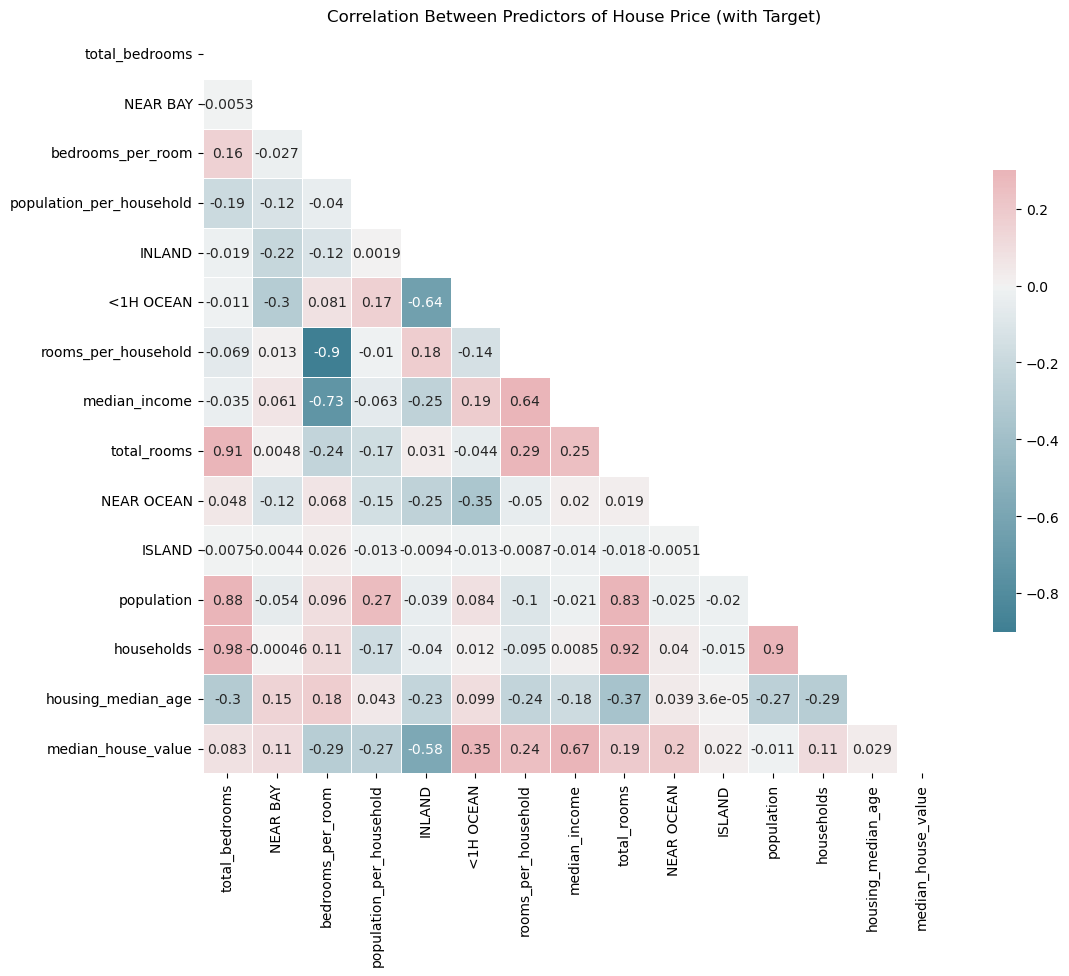

In [47]:
all_train = X_train_scaled.copy()
all_train['median_house_value'] = y_train
make_heatmap(all_train, 'Correlation Between Predictors of House Price (with Target)')

Ok so based on both 1) which correlations had the greatest absolute value in the last row of the plot above, and 2) which columns had the lowest correlations to each other, let's try this again:

In [48]:
independent_features2 = [
    'median_income', 'INLAND', 'population_per_household',
    '<1H OCEAN', 'total_rooms',
]
linreg2 = LinearRegression()
linreg2.fit(X_train_scaled[independent_features2], y_train)
y_pred2 = linreg2.predict(X_test_scaled[independent_features2])
rmse2 = metrics.mean_squared_error(y_test, y_pred2)
print(f'train: rmse={rmse2}')

train: rmse=8.623518738801726


Progress! The error has decreased to about 8.6, but it's still higher than 8.2. Let's add 1 more feature. Here I chose 'NEAR OCEAN' because it doesn't seem to have any strong multicolinearities:

In [49]:
independent_features3 = [
    'median_income', 'INLAND', 'population_per_household',
    '<1H OCEAN', 'total_rooms', 'NEAR OCEAN'
]
linreg3 = LinearRegression()
linreg3.fit(X_train_scaled[independent_features3], y_train)
y_pred3 = linreg3.predict(X_test_scaled[independent_features3])
rmse3 = metrics.mean_squared_error(y_test, y_pred3)
print(f'train: rmse={rmse3}')

train: rmse=8.526409969600477


Not quite!

For my 4th attempt, I'll switch to using an approach based on stochastic gradient descent. We'll use the `SGDRegressor`.

For additional optimizations, we'll do the following:
- use the `'optimal'` learning rate schedule. According to the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), this makes it so that the learning rate is set using `eta = 1.0 / (alpha * (t + t0))`, where `t0` is chosen by a heuristic proposed by Leon Bottou.
- I also set `average=True` - unlike how SGD usually works, this will use averaged SGD weights across all updates to update the model parameters. We can reliably use this to increase our chances of converging to the global minimum of the error function:

In [81]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, SGDRegressor

In [77]:
linreg4 = SGDRegressor(learning_rate='optimal', average=True, random_state=0)
linreg4.fit(X_train_scaled[independent_features3], y_train)
y_pred4 = linreg4.predict(X_test_scaled[independent_features3])
rmse4 = metrics.mean_squared_error(y_test, y_pred4)
print(f'Test : rmse={rmse4}')

Test : rmse=4.01673094289048e+19


Tada! We're now at `4.017` for the mean squared error, which is roughly half of the model we saw in class. :)

b)	[10 points] Suppose the worst scenario is when the RMSE of new model is higher but within 5% with the same number of features that the original model had. Train five different models (with or without regularizations) and report the results. Select the best model among five models and explain why. 

## Model 1: Linear Regression

In the previous question, I used correlation heatmap to ascertain what were the best features to use for the model.

But now I am curious to try if we could achieve solid performance with principal components of the data?

In [52]:
from sklearn import model_selection
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=10)  # roughly same number of features
p = principal_components = pca.fit_transform(X_train_scaled)

In [63]:
p.shape

(10383, 10)

In [64]:
new_model_pca = LinearRegression()
model3 = new_model_pca  # abbreviation
model_selection.cross_val_score(
    model3, p, y_train,
    cv=5, scoring=metrics.make_scorer(metrics.mean_squared_error)
)

array([8.25103811, 8.30001325, 8.69512475, 8.41658559, 8.80333873])

The best model out of these 5 appears to have an error of 8.25. As we can see from the array of mean squared error values above, it's about the same as the model from class which had more features. On the other hand, because we used PCA it's going to be a lot less explainable.

## Model 2: SGD Regression, with Regularization

So earlier I was able to reach a very low error using `SGDRegressor`. But now I'm afraid if that might have caused overfitting. So let's try increasing the `alpha` parameter, in order to increase the strength of our l2 regularization (which is used by default):

In [78]:
sgd_reg= SGDRegressor(learning_rate='optimal', alpha=.0005, average=True, random_state=0)  # 5X increase in alpha
sgd_reg.fit(X_train_scaled[independent_features3], y_train)
y_pred5 = sgd_reg.predict(X_test_scaled[independent_features3])
rmse5 = metrics.mean_squared_error(y_test, y_pred5)
print(f'Test: rmse={rmse5}')

Test: rmse=2.377144476033382e+18


Very intriguing! We managed to go from a test error of ~4 to ~2, again nearly doubling in performance. I also feel alot better that we've increased the regularization parameter.

In terms of explanation, the only thing I can think of is that increasing the `alpha` value increased the penalization on the cost function. Perhaps this led to the model not hopping out of global minima during gradient descent.

## Model 3: Closed-Form Ridge Regression

Even though we have tried l2 regularization with gradient descent, it'd nonetheless be interesting to see the performance of a model not using that as an optimization technique (and we'll use the same `alpha` value here).

In [82]:
ridge_reg = Ridge(alpha=0.005, solver='cholesky')  # 2nd param ensures a closed form solution
ridge_reg.fit(X_train_scaled[independent_features3], y_train)
y_pred6 = ridge_reg.predict(X_test_scaled[independent_features3])
rmse6 = metrics.mean_squared_error(y_test, y_pred6)
print(f'test: rmse={rmse6}')

test: rmse=8.526409808357943


Suprising! A huge difference to the 2nd model, eh?
I suppose this somewhat makes sense. Even though both are operating on the same exact features of the dataset and had the same value for `alpha`, the SGD regressor was able to take a lot more "steps" towards reaching the global minima of the cost function, where as this did not.

## Model 4: Lasso Regression

For fun let's just try switching to l1 regularization. Since this can handle feature selection for us, I will throw all the features at the model:

In [86]:
lasso_reg = Lasso(alpha=0.005, random_state=0)
lasso_reg.fit(X_train_scaled, y_train)
y_pred7 = lasso_reg.predict(X_test_scaled)
rmse7 = metrics.mean_squared_error(y_test, y_pred7)
print(f'test: rmse={rmse7}')

test: rmse=8.259378200320365


So not a lot better than using model 3, which was about ~8.5 for the error. This indicates that even by self-selecting features, this model was not much better than our closed form Ridge regressor.

The intuitive reason here - my understanding is that, while l2 regularization tries to estimate around the mean of our data, l1 does so around the median. But in this case since we have scaled our data to be Gaussian, those values are nearly the same, and it doesn't make a big difference at the end of the day.

## Model 5: Elastic Regression

For our last model, I'll combine l2 and l1 regularization, on the set of independent features we've identified already. This could be the best of both worlds:

In [89]:
elastic_reg = ElasticNet(alpha=0.0001, random_state=0)
elastic_reg.fit(X_train_scaled[independent_features3], y_train)
y_pred8 = elastic_reg.predict(X_test_scaled[independent_features3])
rmse8 = metrics.mean_squared_error(y_test, y_pred8)
print(f'test: rmse={rmse8}')

test: rmse=8.526387473399208


It's admittedly easy to miss, but this model's error - `8.526` is indeed lower than those of our model 4 and 3. This could be due to the fact we were intentional about selecting the right features, and also used both kinds of regularization to avoid overfitting to the training data.

## Which Model Wins?

Based on RMSE, the clear winner amongst the models I trained is 2nd, the `SGDRegressor` which had a test RMSE of only ~2.377.

In terms of explanation, the only thing I can think of is that increasing the `alpha` value increased the penalization on the cost function. Perhaps this led to the model not hopping out of global minima during gradient descent. Also it's very likely heuristic used for the learning schedule is also helping the model optimize for predicting the value of the home prices, since it's the only I trained here that used that schedule.